In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner
from frank.utilities import convolve_profile

In [3]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

In [4]:
from scipy.special import j0
from scipy.stats import binned_statistic

In [5]:
rad_to_arcsec = 3600 * 180 / np.pi

In [6]:
from scipy.optimize import curve_fit

In [7]:
def deproject(u, v, Re, Im, inc, pa, dRa, dDec, inverse=False):
    '''
    Deprojects or projects visibilities
    '''
    # Convert to radian
    pa  = pa  * np.pi / 180.
    inc = inc * np.pi / 180.
    dDec *= np.pi / (180. * 3600)
    dRa  *= np.pi / (180. * 3600)
    # Correct the phase position by dRA and dDec
    if not inverse:
        Intensity = (Re + Im * 1j) * np.exp(2j * np.pi * (u * -dRa + v * -dDec))
        # Calculate deprojected arrays
        Rep = np.real(Intensity)
        Imp = np.imag(Intensity)
    # Calculate transformation
    cos_t = np.cos(pa)
    sin_t = np.sin(pa)
    aux = 1.
    if inverse:
        sin_t *= -1.
        aux = 1. / np.cos(inc)
    up = u * aux * cos_t - v * sin_t
    vp = u * aux * sin_t + v * cos_t
    #   Deproject
    if not inverse:
        up *= np.cos(inc)
    if inverse:
        Intensity = (Re + Im * 1j) * np.exp(2j * np.pi * (up * -dRa + vp * -dDec))
        # Calculate deprojected arrays
        Rep = np.real(Intensity)
        Imp = np.imag(Intensity)
    # Return
    return up, vp, Rep, Imp


In [8]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

In [9]:
def gauss(r, sigma):
    return np.exp(-0.5*((r-Rout/2.)/sigma)**2)

In [10]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

In [11]:
# Deprojection
du, dv, dRe, dIm = deproject(u=u, v=v, Re=Re, Im=Imag,
                             inc=inc, pa=pa, dRa=dra, dDec=ddec,
                             inverse=False)
dbaseline = np.sqrt(du**2 + dv**2)

In [12]:
Re_deltaR = np.median(Re[np.where(dbaseline<3e4)])*np.real(j0(2.*np.pi*(Rout/rad_to_arcsec/2.)*dbaseline))

In [13]:
u_ring = u
v_ring = v
Re_ring = Re_deltaR
Imag_ring = np.zeros(len(Re))

In [14]:
Vis_ring = Re_ring + Imag_ring*1j

In [15]:
N = 300

In [139]:
m, c, l = -0.33, -0.1, 1.5e5

## Frank2D

In [197]:
frank2d0 = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d0.preprocess_vis(u, v, Vis_ring, Weights)
vis_gridded = frank2d0._gridded_data['vis']

Deprojecting...
  --> time = 0.04  min |  2.60 seconds
Setting gridded data...


In [198]:
FT = frank2d._FT
x_labels = np.fft.fftshift(FT._u/1e6)
y_labels = np.fft.fftshift(FT._v/1e6)

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

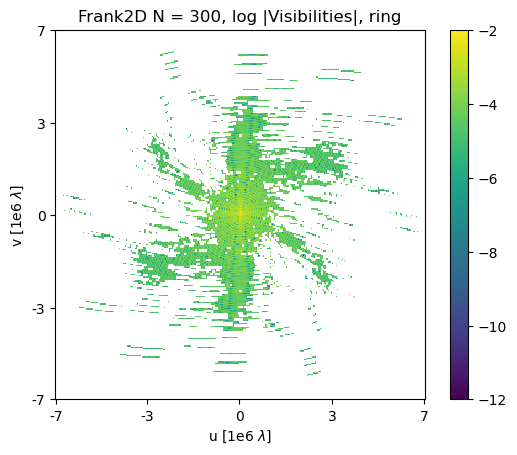

In [200]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, log |Visibilities|, ring')
plt.colorbar()

In [140]:
frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u_ring, v_ring, Vis_ring, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

Setting kernel: Wendland...
Gridding...
Deprojecting...
  --> time = 0.04  min |  2.60 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 8.28  min |  496.72 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 1.7774038410111224e-09
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
        

In [141]:
frank2d.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


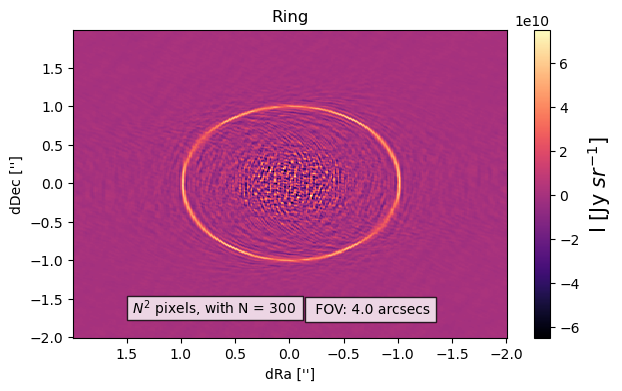

In [142]:
Plot(frank2d).get_image('Ring')

In [164]:
vis_sol = frank2d.sol_visibility.reshape(frank2d._FT._Nx, frank2d._FT._Ny)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_21243/1470016184.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol.real))), origin='lower', vmin=-12, vmax=-2)


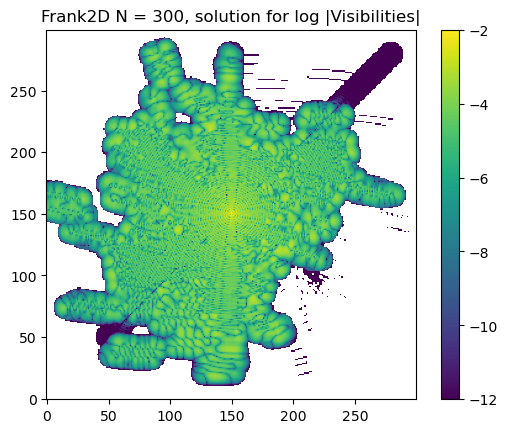

In [165]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol.real))), origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

In [143]:
r, I = get_radial_profile(frank2d)

In [223]:
popt_frank2d, cov = curve_fit(gauss, r, I/np.max(I), p0=[0.09])
FWHM_frank2d = popt[0]* 2. *np.sqrt(2.*np.log(2.))
Error_FWHM = np.sqrt(cov[0][0])* 2. *np.sqrt(2.*np.log(2.)) 

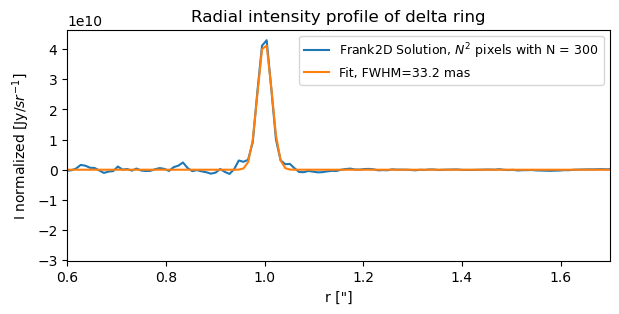

In [206]:
plt.close()
plt.figure(figsize=(7,3))
plt.plot(r, I, color='C0',label= r'Frank2D Solution, $N^{2}$ pixels with N = ' + str(N))
plt.plot(r, gauss(r, *popt)*np.max(I), color='C1', label='Fit, FWHM=%.1f mas'%(FWHM*1000))
plt.ylabel(r'I normalized [Jy/$sr^{-1}$]')
plt.xlabel('r ["]')
plt.xlim(0.6, 1.7)
plt.title('Radial intensity profile of delta ring')
plt.legend(loc='best', fontsize = 9)

In [216]:
print ('FWHM=', FWHM_frank2d, '+/-', Error_FWHM, 'arcsec')   

FWHM= 0.03316545364637202 +/- 0.0012602529846603796 arcsec


### Frank1D

In [147]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-3

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u_ring, v_ring, Vis_ring, Weights)

In [148]:
popt_frank1d, cov_frank1d = curve_fit(gauss, sol.r, sol.mean/np.max(sol.mean), p0=[0.009])
FWHM_frank1d = popt_frank1d[0]* 2. *np.sqrt(2.*np.log(2.))
Error_FWHM_frank1d = np.sqrt(cov_frank1d[0][0])* 2. *np.sqrt(2.*np.log(2.))

In [149]:
FWHM_frank1d

0.01511138647329329

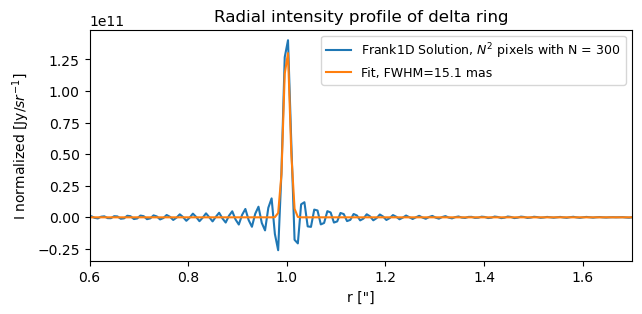

In [220]:
plt.close()
plt.figure(figsize=(7,3))
plt.plot(sol.r, sol.mean, color='C0',label= r'Frank1D Solution, $N^{2}$ pixels with N = ' + str(n_pts))
plt.plot(sol.r, gauss(sol.r, *popt_frank1d)*np.max(sol.mean), color='C1', label='Fit, FWHM=%.1f mas'%(FWHM_frank1d*1000))
plt.ylabel(r'I normalized [Jy/$sr^{-1}$]')
plt.xlabel('r ["]')
plt.xlim(0.6, 1.7)
plt.title('Radial intensity profile of delta ring')
plt.legend(loc='best', fontsize = 9)

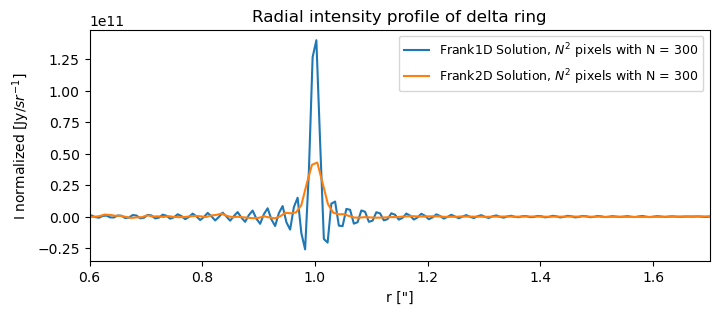

In [202]:
plt.close()
plt.figure(figsize=(8,3))
plt.plot(sol.r, sol.mean,label= r'Frank1D Solution, $N^{2}$ pixels with N = ' + str(n_pts))
plt.plot(r, I, label= r'Frank2D Solution, $N^{2}$ pixels with N = ' + str(N))
plt.ylabel(r'I normalized [Jy/$sr^{-1}$]')
plt.xlabel('r ["]')
plt.xlim(0.6, 1.7)
plt.title('Radial intensity profile of delta ring')
plt.legend(loc='best', fontsize = 9)

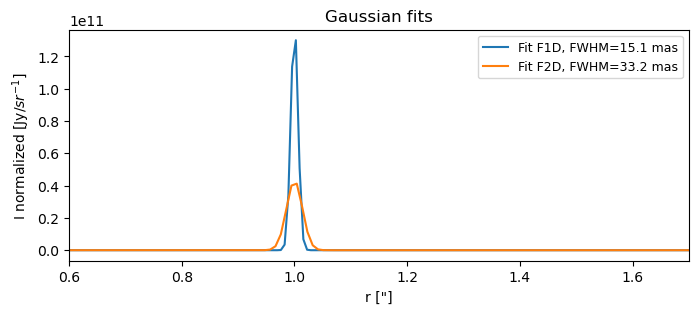

In [224]:
plt.close()
plt.figure(figsize=(8,3))
plt.plot(sol.r, gauss(sol.r, *popt_frank1d)*np.max(sol.mean), label='Fit F1D, FWHM=%.1f mas'%(FWHM_frank1d*1000))
plt.plot(r, gauss(r, *popt_frank2d)*np.max(I), label='Fit F2D, FWHM=%.1f mas'%(FWHM*1000))
plt.ylabel(r'I normalized [Jy/$sr^{-1}$]')
plt.xlabel('r ["]')
plt.xlim(0.6, 1.7)
plt.title('Gaussian fits')
plt.legend(loc='best', fontsize = 9)

In [156]:
sigma_final = np.sqrt(FWHM_frank2d**2 - FWHM_frank1d**2)
sigma_final

0.02952275926170215

In [162]:
beam_1mm = {'bmaj':sigma_final, 'bmin':sigma_final, 'beam_pa':geom.PA}
convolved_frank1d = convolve_profile(sol.r, sol.mean, geom.inc, geom.PA, beam_1mm)

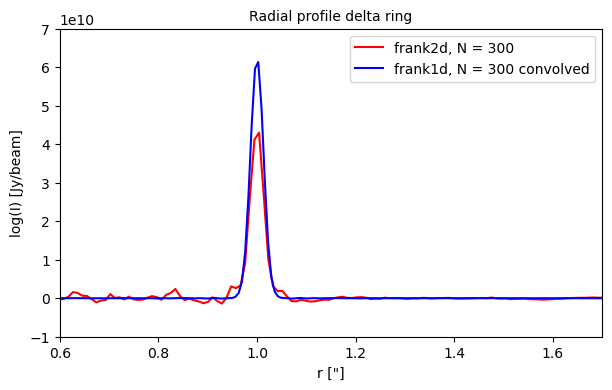

In [228]:
plt.figure(figsize=(7, 4))
plt.plot(r, I, "red", label=r'frank2d' + ', N = ' +str(n_pts))
plt.plot(sol.r, convolved_frank1d, "blue", label=r'frank1d' + ', N = ' +str(N)+ ' convolved')
plt.title(r'Radial profile delta ring', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.xlim(0.6, 1.7)
plt.ylim(-1e10, 7e10)
plt.legend(fontsize=10)
plt.show()

In [166]:
popt_frank1d_conv, cov_frank1d_conv = curve_fit(gauss, sol.r, convolved_frank1d/np.max(convolved_frank1d), p0=[0.009])
FWHM_frank1d_conv = popt_frank1d_conv[0]* 2. *np.sqrt(2.*np.log(2.))
Error_FWHM_frank1d_conv = np.sqrt(cov_frank1d[0][0])* 2. *np.sqrt(2.*np.log(2.))

In [167]:
FWHM_frank1d_conv

0.0315584617936531

In [168]:
FWHM

0.03316545364637202

In [169]:
np.max(convolved_frank1d)/np.max(I)

1.4267224774417322

### Trying with real disk

In [170]:
N = 300
m, c, l = -0.33, -0.1, 1.5e5

In [171]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: Wendland...
Gridding...
Deprojecting...
  --> time = 0.03  min |  2.02 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 5.57  min |  333.95 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 6.166140882391303e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
         

In [172]:
frank2d.fft()

Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


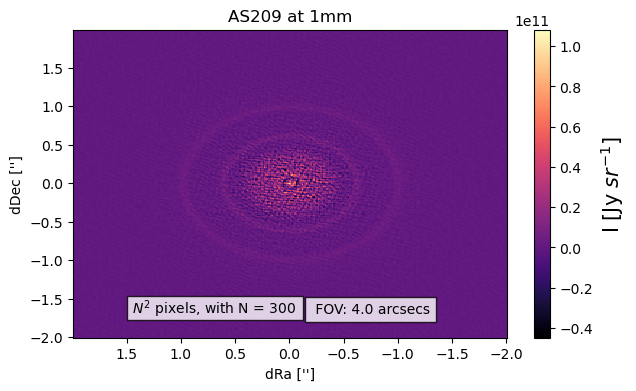

In [173]:
Plot(frank2d).get_image('AS209 at 1mm')

In [174]:
r_disk, I_disk = get_radial_profile(frank2d)

In [187]:
np.savez(str(dir) + "radialProfile_F2D_AS209_1mm_n300pts_1p5e5", arreglo = [r_disk,I_disk])

In [175]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-3

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol_disk = FF.fit(u, v, Vis, Weights)

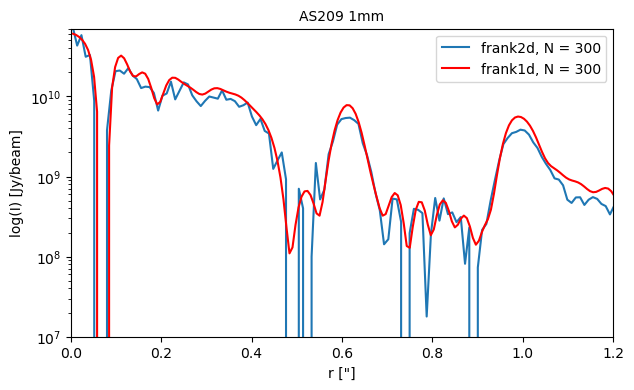

In [229]:
plt.figure(figsize=(7, 4))
plt.plot(r_disk, I_disk, label=r'frank2d' + ', N = ' +str(N)+'')
plt.plot(sol_disk.r, sol_disk.mean, "red", label=r'frank1d' + ', N = ' +str(N)+ '')
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
plt.xlim(0,1.2)
plt.ylim(1e7, 7e10)
plt.yscale('log')
plt.show()

In [209]:
beam_1mm = {'bmaj':sigma_final, 'bmin':sigma_final, 'beam_pa':pa}
convolved_frank1d_disk = convolve_profile(sol_disk.r, sol_disk.mean, geom.inc, geom.PA, beam_1mm)

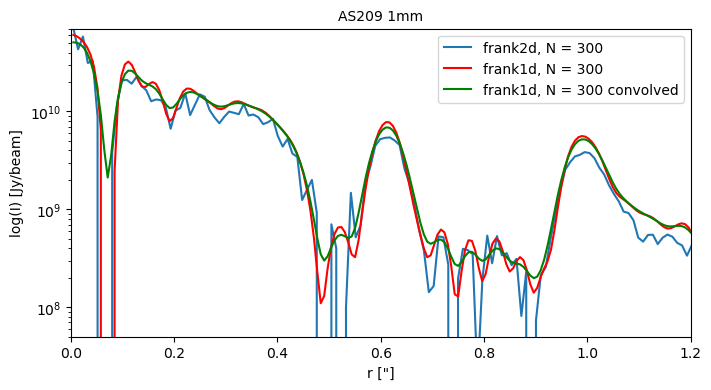

In [233]:
plt.figure(figsize=(8, 4))
plt.plot(r_disk, I_disk, label=r'frank2d' + ', N = ' +str(n_pts)+'')
plt.plot(sol_disk.r, sol_disk.mean, "red", label=r'frank1d' + ', N = ' +str(N)+ '')
plt.plot(sol_disk.r, convolved_frank1d_disk, "green", label=r'frank1d' + ', N = ' +str(N)+ ' convolved')
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
plt.xlim(0,1.2)
plt.yscale('log')
plt.ylim(5e7, 7e10)
plt.show()

In [217]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [218]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r_disk, I_disk, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol_disk.r, convolved_frank1d_disk, inc, pa, clean_beam_1mm)*area_1mm

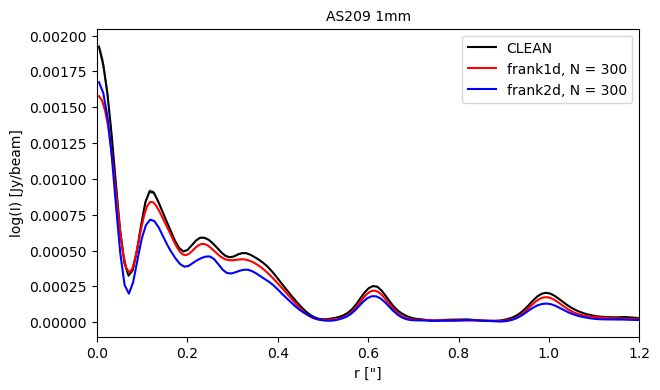

In [219]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()